# Import Libraries

In [5]:
import math
from math import sqrt
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as spatial
import scipy.cluster as cluster
from collections import defaultdict
from statistics import mean
# import imutils
# from skimage import exposure
# import argparse
import random

# Util Funtions

## Random Color

In [17]:
def random_color(mode = "rgb"):

    if mode != "rgb":
        return np.random.randint((1, )).astype(np.int32)

    r, g, b = tuple(np.random.randint(0, 255, (3, )).astype(int))
    
    return int(r), int(g), int(b)

## Order coordinates

In [19]:
def order_points_clockwise(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]

    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    # now, sort the right-most coordinates according to their
    # y-coordinates so we can grab the top-right and bottom-right
    # points, respectively
    rightMost = rightMost[np.argsort(rightMost[:, 1]), :]
    (tr, br) = rightMost

    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="int32")

## Distance

In [20]:
def distance(p, q):
    return sqrt(sum((px - qx) ** 2.0 for px, qx in zip(p, q)))

## Canny Edge

In [ ]:
def canny_edge(rgb_img, low_thresh = 50, high_thresh = 150):
    gray_image = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_image, low_thresh, high_thresh)
    return edges

## Hough Lines Transform

In [21]:
def hough_line(edges, min_line_length=100, max_line_gap=10):
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 125, min_line_length, max_line_gap)
    lines = np.reshape(lines, (-1, 2))
    return lines

# Show Image

In [24]:
def show_image(img, img_title="", mode="rgb"):

    if mode != "rgb":
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)

    plt.title(img_title)
    plt.axis("off")
    plt.show()

# Trial

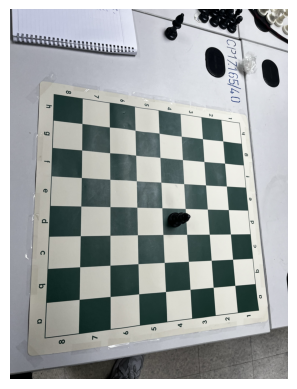

In [32]:
image = cv2.imread("../data/BlackBishop_2305.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
show_image(image)

In [33]:
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

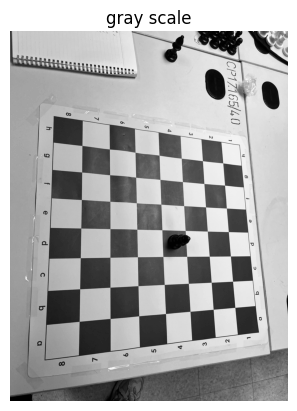

In [34]:
show_image(gray_image, "gray scale", "gray")

In [ ]:
# Define the number of inner corners per row and column (e.g., 7x7 grid)
pattern_size = (7, 7)

# Find the corners of the chessboard
found, corners = cv2.findChessboardCorners(gray_image, pattern_size, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE)

if found:
    print("Chessboard detected!")
    # Draw the corners on the image
    cv2.drawChessboardCorners(image, pattern_size, corners, found)
else:
    print("Chessboard not detected.")

Chessboard not detected.


In [45]:
def selectPoints(corners, dth = 5, nth = 8):
    """
    Keep points that lie on a line with others to remove outliers.

    Args:
        corners (numpy.ndarray): Array of points (Nx1x2) returned by cv2.goodFeaturesToTrack.
        dth (float): Distance threshold for determining if points are aligned.
        nth (int): Minimum number of neighbors required along an axis.

    Returns:
        list: Filtered list of points that satisfy the criteria.
    """
    res = []
    
    # Convert corners to a more accessible format if necessary
    corners = np.squeeze(corners)  # Remove redundant dimensions (if needed)
    if len(corners.shape) == 1:    # Handle single-point case
        corners = [corners]

    for p in corners:
        nx, ny = 0, 0
        x, y = p[0], p[1]

        for q in corners:
            x2, y2 = q[0], q[1]
            if abs(x - x2) < dth:
                nx += 1
            if abs(y - y2) < dth:
                ny += 1

        if nx > nth and ny > nth:
            res.append((x, y))
    
    return res

In [46]:
def detectBoard(img):
    """
    Detect the points of the board using Shi-Tomasi corner detection.
    """
    # Clone and preprocess the input image
    detected = img.copy()
    detected = cv2.cvtColor(detected, cv2.COLOR_RGB2GRAY)
    detected = cv2.equalizeHist(detected)
    detected = cv2.normalize(detected, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    _, detected = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Erode and dilate to remove noise
    detected = cv2.erode(detected, None, iterations=1)
    detected = cv2.dilate(detected, None, iterations=1)

    # Prepare mask and result image
    mask = np.zeros_like(detected, dtype=np.uint8)
    res = np.zeros_like(detected, dtype=np.uint8)

    # Find contours and convex hull
    contours, _ = cv2.findContours(detected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    big_blob = max(contours, key=lambda x: cv2.contourArea(x))  # Find the largest contour
    hull = cv2.convexHull(big_blob)

    # Extract ROI and draw the largest contour
    ROI = cv2.boundingRect(hull)
    temp = [hull]
    cv2.drawContours(mask, temp, -1, 255, -1)

    # Apply mask
    detected = cv2.bitwise_and(detected, mask)
    dst = detected.copy()

    # Shi-Tomasi corner detection
    corners = cv2.goodFeaturesToTrack(dst, maxCorners=90, qualityLevel=0.01, minDistance=10, mask=None, blockSize=3, useHarrisDetector=False, k=0.04)

    # Placeholder for point selection, assuming selectPoints function exists
    lock = selectPoints(corners)

    # Convert mask back to color for visualization if needed
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    show_image(dst, mode="gray")

    # Return the results (update according to your application)
    return ROI, lock

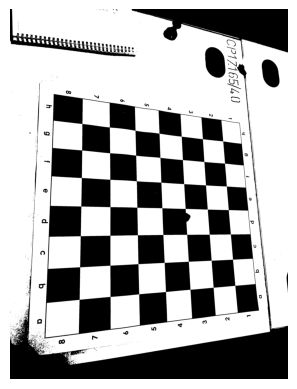

In [47]:
roi, lock = detectBoard(image)

In [55]:
roi

(0, 0, 3024, 3878)